# Q Learning project

Projecto realizado para la asignatura de Inteligencia Artificial de la titulación Grado en Ingeniería Informática - Ingeniería del Software de la Universidad de Sevilla.

## Alumnos

- Muñoz Aranda, Alejandro José <alemunara@alum.us.es>
- Ruano Fernández, Mario <mruano@us.es>

## Código fuente

Los siguientes bloques corresponden al código fuente de este trabajo. Es necesario su ejecución para el correcto funcionamiento del programa y de los algoritmos que se utilizan a través de una interfaz gráfica de usuario.

De manera general, para la resolución de los problemas presentados, se ha seguido el paradigma de la programación orientada a objetos, modulándose cada uno de los objetos que entran en juego en el dominio del problema.

La decisión de diseño no ha sido otra que la de poder reutilizar al máximo el código escrito y que el usuario pueda generar distintos escenarios, bien configurados de manera manual o generados de forma aleatoria a partir de una serie de parámetros, y que los algoritmos de entrenamiento y resolución pueda aplicarse debidamente.

In [180]:
from numpy import *
from random import *
import matplotlib.pyplot as plt

### Tablero (Board)

Se ha creado una clase que representa al tablero (Board) con los siguientes atributos:

- n: número de filas del tablero
- m: número de columnas del tablero
- initial_state: casilla desde la que se desea partir
- goal_state: casilla objetivo que se pretende alcalzar
- map_squares: diccionario que relaciona una coordenada del tablero (clave), mediante una tupla, con un número de casilla (valor).
- map_states: diccionario que relaciona un número de casilla (clave), mediante un entero único de ``0 a (n*m)-1``, con una coordenada del tablero, mediante una tupla (valor).


In [181]:
class Board():
    def __init__(self, n, m, initial_state, goal_state):
        self.__n = n
        self.__m = m
        self.__initial_state = initial_state
        self.__goal_state = goal_state
        self.__map_squares = {}
        self.__map_states = {}
    
    def get_n(self):
        return self.__n
    
    def get_m(self):
        return self.__m

    def get_size(self):
        return self.__n * self.__m

    def get_map_states(self):
        return self.__map_states
    
    def get_initial_state(self):
        return self.__initial_state
    
    def get_goal_state(self):
        return self.__goal_state

    def init_random_board(self):
        states = sample([i for i in range(self.get_size())], self.get_size())
        k = 0

        for i in range(self.__n):
            for j in range(self.__m):
                state = states[k]
                self.__map_squares[(i, j)] = state
                self.__map_states[state] = (i, j)
                k = k + 1
    
    def is_neighbor(self, square_src, square_dst):
        distance = sqrt(power(square_dst[0] - square_src[0], 2) +
                    power(square_dst[1] - square_src[1], 2))
        return distance <= sqrt(2) and distance > 0
    
    def customize_board(self, matrix_board):
        for i in range(self.__n):
            for j in range(self.__m):
                state = matrix_board[i, j]
                self.__map_squares[(i, j)] = state
                self.__map_states[state] = (i, j)

In [213]:
class R():
    def __init__(self, board):
        self.__board = board
        self.__matrix = self.__get_matrix()
        
    def get_R(self):
        return self.__matrix

    def __get_matrix(self):
        size = self.__board.get_size()
        R = zeros((size, size))
        
        for i in range(size):
            for j in range(size):
                if (self.__board.is_neighbor(self.__board.get_map_states()[i], self.__board.get_map_states()[j])):
                    if (j == self.__board.get_goal_state()):
                        R[i, j] = 100
                    else:
                        R[i, j] = 0
                elif (i == self.__board.get_goal_state() and i == j):
                    R[i, j] = 100
                else:
                    R[i, j] = -100
        
        return R

In [183]:
class QLearningAlgorithm():
    def __init__(self, board, R, n_training, gamma):
        self.__board = board
        self.__R = R
        self.__n_training = n_training
        self.__gamma = gamma
        self.__Q = zeros((board.get_size(), board.get_size()))
        
    def get_Q(self):
        return self.__Q
    
    def training(self):
        goal_state = self.__board.get_goal_state()
        performances = []
        for i in range(self.__n_training):
            current_state = choice(list(range(self.__board.get_size())))
            while True:
                possible_actions = {}
                actions = self.__R[current_state]
                for i in range(self.__board.get_size()):
                    if (actions[i] >= 0):
                        possible_actions[i] = actions[i]
                next_state = choice(list(possible_actions.keys()))
                action = next_state                
                self.__Q[current_state, action] = self.__R[current_state, action] + self.__gamma * max(self.__Q[next_state])
                current_state = next_state
                if (current_state == goal_state):
                    break
            performances.append(self.__calculate_performance())
        self.__normalize_Q()
        return performances
    
    def get_path(self):
        map_states = self.__board.get_map_states()
        goal_state = self.__board.get_goal_state()
        current_state = self.__board.get_initial_state()
        path = [(current_state, map_states[current_state])]
        
        while (current_state != goal_state):
            actions = self.__Q[current_state]
            max_val = max(actions)
            current_state = where(actions == max_val)[0][0]
            path.append((current_state, map_states[current_state]))
        
        return path
    
    def __calculate_performance(self):
        performance = 0
        
        for i in range(self.__board.get_size()):
            for j in range(self.__board.get_size()):
                performance = performance + self.__Q[i, j]
                
        max_value = self.__get_max_value()
        
        return (performance / max_value) * 100
    
    def __get_max_value(self):
        values = []
        for i in range(self.__board.get_size()):
            actions = self.__Q[i]
            values.append(max(actions))    
        return max(values)
    
    def __normalize_Q(self):
        max_value = self.__get_max_value()
        
        for i in range(self.__board.get_size()):
            for j in range(self.__board.get_size()):
                self.__Q[i, j] = round((self.__Q[i, j] / max_value) * 100)

In [214]:
class QLearningVariantAlgorithm(QLearningAlgorithm):
    def __init__(self, board, R, n_training, gamma, epsilon, alpha):
        super().__init__(board, R, n_training, gamma)
        self.__epsilon = epsilon
        self.__alpha = alpha

    def training(self):
        goal_state = self._QLearningAlgorithm__board.get_goal_state()
        performances = []
        for i in range(self._QLearningAlgorithm__n_training):
            current_state = choice(list(range(self._QLearningAlgorithm__board.get_size())))
            epsilon = self.__epsilon
            while True:
                possible_actions = {}
                actions = self._QLearningAlgorithm__R[current_state]
                for i in range(self._QLearningAlgorithm__board.get_size()):
                    if (actions[i] >= 0):
                        possible_actions[i] = actions[i]
                
                # who is next_state (variant)
                k = random()
                if (k > epsilon):
                    max_val = max(self._QLearningAlgorithm__Q[current_state])
                    next_state = where(self._QLearningAlgorithm__Q[current_state] == max_val)[0][0]
                else:
                    next_state = choice(list(possible_actions.keys()))
                epsilon = epsilon * self.__alpha
                # end (variant)
                
                action = next_state
                self._QLearningAlgorithm__Q[current_state, action] = self._QLearningAlgorithm__R[current_state, action] + self._QLearningAlgorithm__gamma * max(self._QLearningAlgorithm__Q[next_state])
                current_state = next_state
                if (current_state == goal_state):
                    break
            performances.append(self._QLearningAlgorithm__calculate_performance())
        self._QLearningAlgorithm__normalize_Q()
        return performances

In [90]:
board = Board(3,3,0,6)

# Ejemplo manual de Fase 1
config_board = array([[8,7,6],
                      [3,2,5],
                      [0,1,4]])
board.customize_board(config_board)

# Caso random
#board.init_random_board()

RMatrix = R(board)

In [215]:
n_training = 150

In [92]:
# Fase 1
agent1 = QLearningAlgorithm(board, RMatrix.get_R(), n_training, 0.8)
performance1 = agent1.training()
print(agent1.get_path())

[(0, (2, 0)), (2, (1, 1)), (6, (0, 2))]


In [42]:
# Fase 2
agent2 = QLearningVariantAlgorithm(board, RMatrix.get_R(), n_training, 0.8, 0.9999, 0.9999)
performance2 = agent2.training()
print(agent2.get_path())

[(0, (2, 3)), (2, (3, 2)), (10, (3, 1))]


In [216]:
# Fase 3
board3 = Board(10,10,0,99)

config_board3 = array([
    [0,15,27,49,71,33,41,72,61,62],
    [3,19,73,28,63,56,40,57,76,77],
    [58,1,94,50,74,20,29,34,39,75],
    [82,4,78,16,21,35,42,46,69,81],
    [70,2,47,64,18,68,23,79,80,43],
    [5,14,22,51,52,91,53,92,97,98],
    [93,10,55,85,17,86,60,26,32,9],
    [87,7,13,30,31,44,84,66,67,99],
    [8,88,48,11,54,25,36,89,95,96],
    [6,12,59,83,90,24,65,37,38,45],
])

board3.customize_board(config_board3)

basic_R = R(board3)
R = basic_R.get_R()

## Recompensas intermedias
R[0,19]=30
R[19,58]=30
R[70,5]=30
R[10,13]=30
R[90,24]=30
R[38,96]=30
R[27,49]=30
R[33,40]=30
R[34,69]=30
R[43,98]=30

## Penalizaciones
R[18,91]=-10
R[9,99]=-10
R[32,99]=-10
R[67,99]=-10

In [217]:
# Fase 1
agent1 = QLearningAlgorithm(board, R, n_training, 0.9)
performance1 = agent1.training()

In [224]:
print(agent1.get_path())

[(0, (0, 0)), (19, (1, 1)), (58, (2, 0)), (4, (3, 1)), (70, (4, 0)), (5, (5, 0)), (10, (6, 1)), (13, (7, 2)), (11, (8, 3)), (90, (9, 4)), (24, (9, 5)), (36, (8, 6)), (37, (9, 7)), (38, (9, 8)), (96, (8, 9)), (99, (7, 9))]


In [ ]:
# Fase 2 (no se ha probado para el caso de Fase 3)
agent2 = QLearningVariantAlgorithm(board, R, n_training, 0.8, 0.9999, 0.9999)
performance2 = agent2.training()

In [ ]:
print(agent2.get_path())

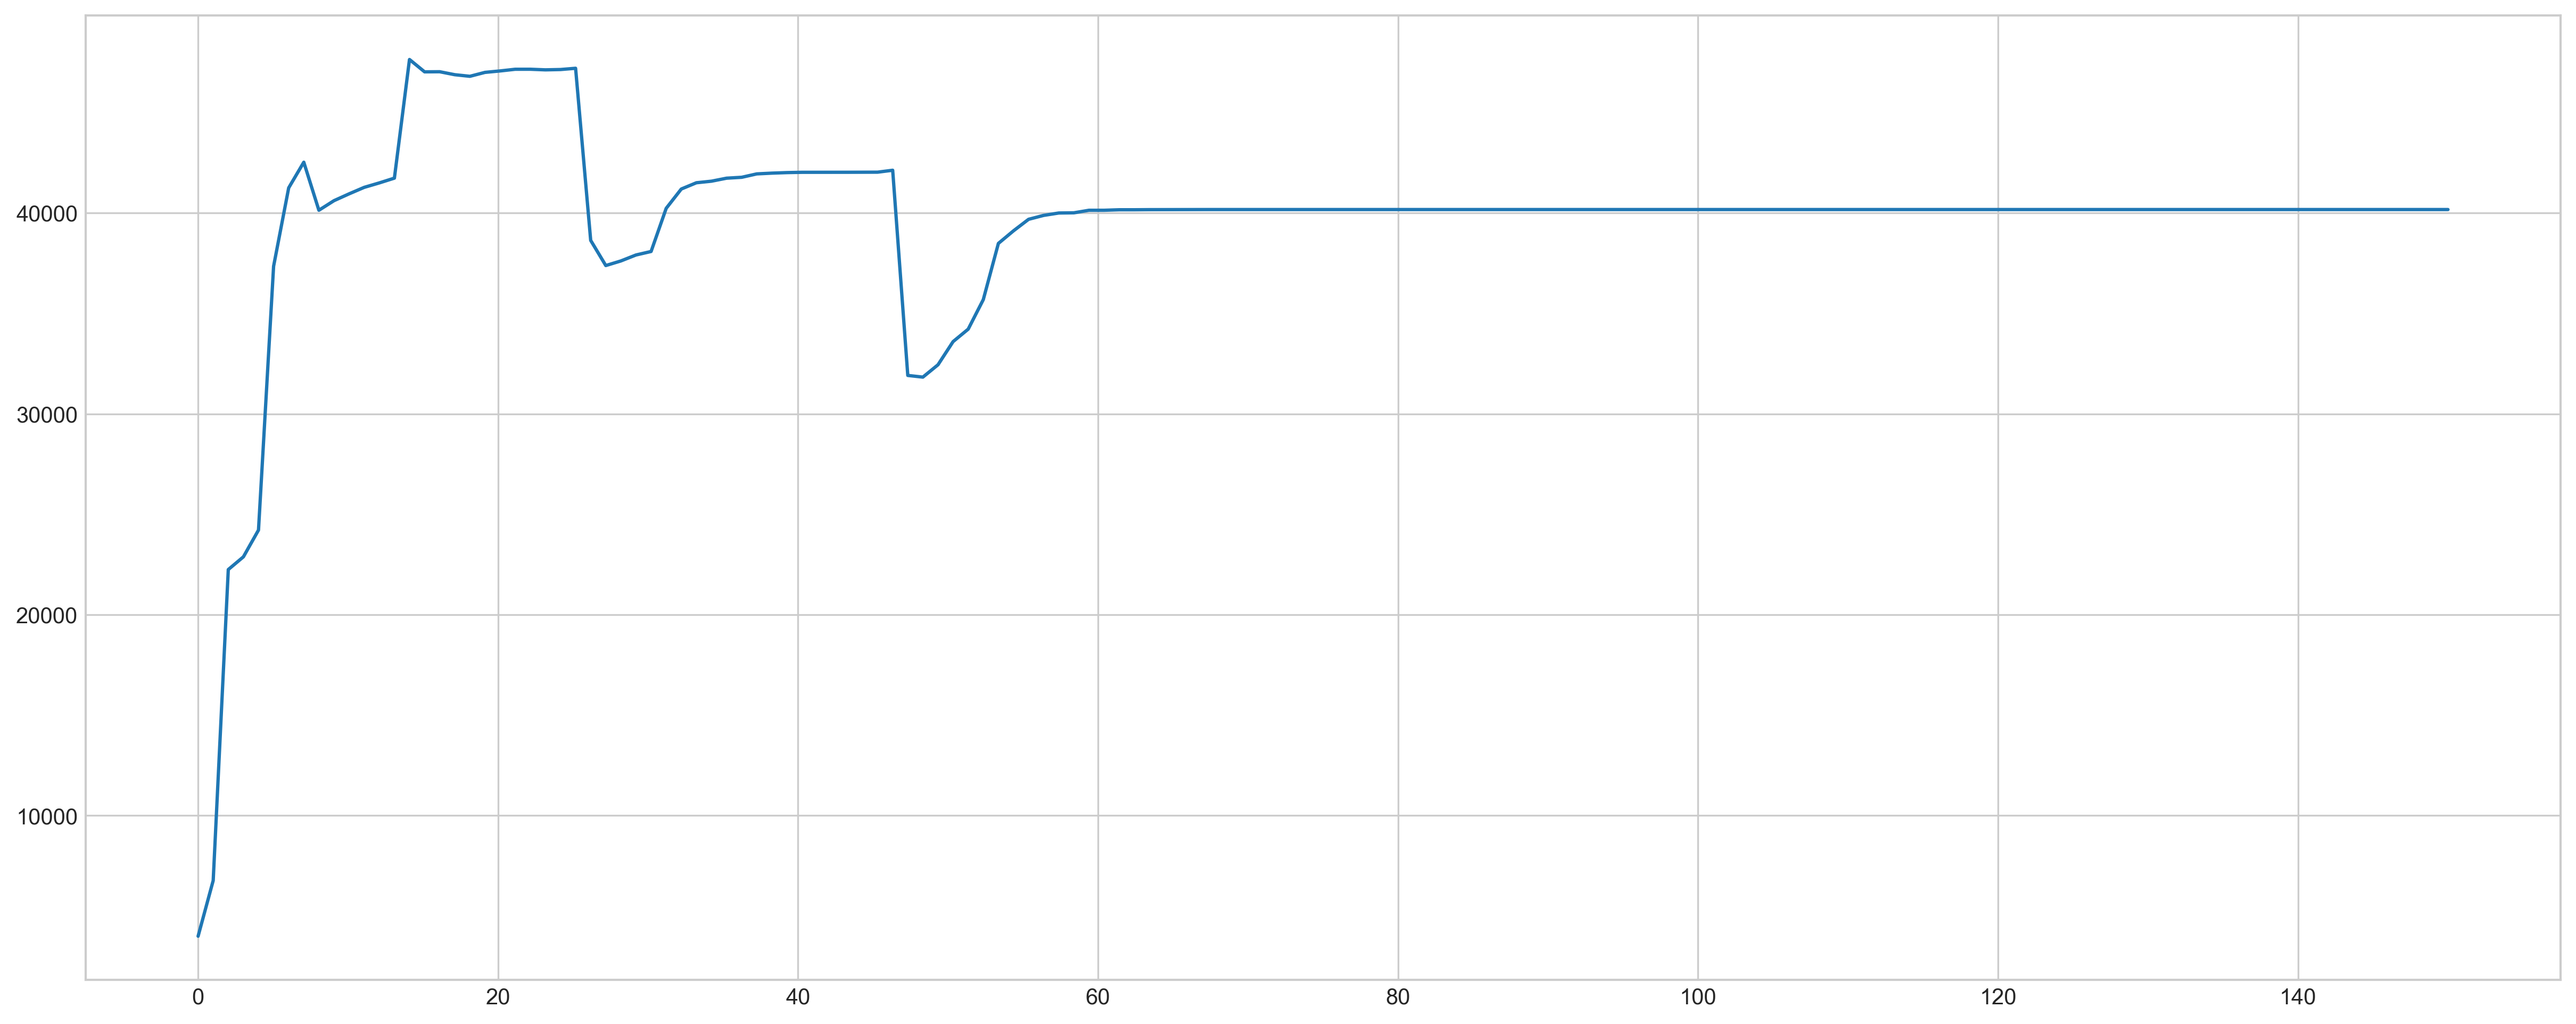

In [225]:
# Este bloque imprime un rendimiento de entrenamiento. En este caso en performance
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,8), dpi=300.)
ax = plt.axes()
x = linspace(0,n_training, n_training)
ax.plot(x, performance1) #modificando performance por una performance, se imprime
plt.show()

In [186]:
# UI

from tkinter import *
from tkinter import ttk

filas = 0
columnas = 0

def crear_tablero() :
    filas = int(entry1.get())
    columnas = int(entry2.get())    
    
    dimension = (filas*columnas)
    estados = sample([x for x in range(0,dimension)],dimension)
    E = np.zeros((filas,columnas))
    k = 0

    for i in range(0,filas) :
        for j in range(0,columnas) :
            E[i,j] = estados[k]
            k = k + 1    

    return E

root = Tk()
root.title("Q Learning AI")

frame = ttk.Frame(root, padding="50")
frame.grid_propagate(0)
frame.pack(side="top")

label1 = Label(frame, text="Filas del tablero")
label1.pack()
label1.config(justify=CENTER)

entry1 = Entry(frame, width=30)
entry1.pack()

label2 = Label(frame, text="Columnas del tablero")
label2.pack()
label2.config(justify=CENTER)

entry2 = Entry(frame, width=30)
entry2.pack()

label3 = Label(frame, text="Estado inicial")
label3.pack()
label3.config(justify=CENTER)

entry3 = Entry(frame, width=30)
entry3.pack()

label4 = Label(frame, text="Estado objetivo")
label4.pack()
label4.config(justify=CENTER)

entry4 = Entry(frame, width=30)
entry4.pack()

button = Button(frame)
button["text"] = "Obtener tablero"
button["command"] = crear_tablero
button.pack()

root.mainloop()
